<a href="https://colab.research.google.com/github/Ahmed-Shatla/CNN-Traffic/blob/main/Detect_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
images = []
labels=[]
path = '/content/drive/MyDrive/Signs data/DATA'
for i in os.listdir(path):
  for j in os.listdir(path+'/'+i):
    image = cv2.imread(path+'/'+i+'/'+j,1)
    images.append(image)
    labels.append(i)


In [4]:
labels[0]

'16'

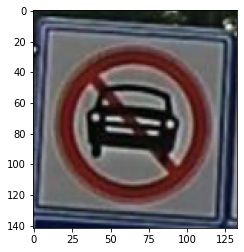

In [5]:
plt.imshow(cv2.cvtColor(images[0],cv2.COLOR_BGR2RGB))

In [6]:
def get_avg_shape(images):
  w = []
  h = []
  for image in images:
    h.append(image.shape[0])
    w.append(image.shape[1])

  return int(np.mean(h)),int(np.mean(w))

In [7]:
avg_h,avg_w = get_avg_shape(images)

In [8]:
def reshape_images(images):
  reshaped_img = []
  for image in images:
    reshaped_img.append(cv2.resize(image,(140,140)))
  return reshaped_img

In [9]:
reshaped_images = reshape_images(images)

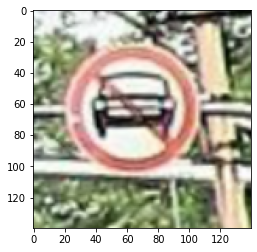

In [10]:
plt.imshow(cv2.cvtColor(reshaped_images[4],cv2.COLOR_BGR2RGB))

In [11]:
reshaped_images[0].shape

(140, 140, 3)

In [12]:
X = reshaped_images

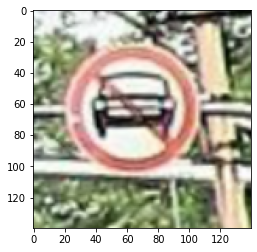

In [13]:
plt.imshow(cv2.cvtColor(X[4],cv2.COLOR_BGR2RGB))

In [14]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
labels = lb.fit_transform(labels)

In [15]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels)

In [18]:
y.shape

(3870, 50)

In [23]:
img = np.array(X)

In [24]:
img.shape

(3870, 140, 140, 3)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(img,y,test_size=0.1)

In [19]:
y =y.reshape(3870, 50,1)

In [49]:
aug_gen = ImageDataGenerator(zoom_range=0.1,rotation_range=45,horizontal_flip=True)
val_gen = ImageDataGenerator()


In [50]:
train = aug_gen.flow(X_train,y_train,batch_size=32)
valid = val_gen.flow(X_valid,y_valid,batch_size=32)

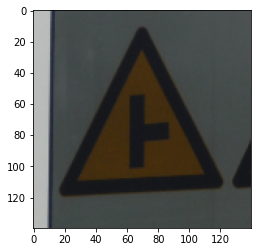

In [51]:
plt.imshow(cv2.cvtColor(X_train[0],cv2.COLOR_BGR2RGB))

#Transfere learning

In [37]:
from tensorflow.keras.applications import VGG16

In [38]:
model = VGG16(weights='imagenet',include_top=False,input_shape=((140,140,3)))
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 140, 140, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 140, 140, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 140, 140, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 70, 70, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 70, 70, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 70, 70, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 35, 35, 128)       0     

In [42]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model

In [40]:
for layer in model.layers:
  layer.trainable = False

In [41]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 140, 140, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 140, 140, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 140, 140, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 70, 70, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 70, 70, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 70, 70, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 35, 35, 128)       0     

In [44]:
model_output = model.output
model_output = Flatten()(model_output)
model_output = Dense(1024,activation='relu')(model_output)
model_output = Dense(512,activation='relu')(model_output)
model_output = Dense(1024,activation='relu')(model_output)


model_output = Dense(50,activation='softmax')(model_output)

final_mode = Model(model.input,model_output)

In [45]:
final_mode.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 140, 140, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 140, 140, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 140, 140, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 70, 70, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 70, 70, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 70, 70, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 35, 35, 128)       0   

In [47]:
final_mode.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [52]:
history = final_mode.fit_generator(train,validation_data=valid,steps_per_epoch=32,epochs=10,verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
32/32 [==============================] - 273s 9s/step - loss: 6.0805 - accuracy: 0.4023 - val_loss: 1.4595 - val_accuracy: 0.6641
Epoch 2/10
32/32 [==============================] - 272s 9s/step - loss: 1.1779 - accuracy: 0.6865 - val_loss: 1.0256 - val_accuracy: 0.7468
Epoch 3/10
32/32 [==============================] - 273s 9s/step - loss: 0.7990 - accuracy: 0.7822 - val_loss: 0.8428 - val_accuracy: 0.8062
Epoch 4/10
32/32 [==============================] - 288s 9s/step - loss: 0.6246 - accuracy: 0.8350 - val_loss: 0.6723 - val_accuracy: 0.8372
Epoch 5/10
32/32 [==============================] - 288s 9s/step - loss: 0.6848 - accuracy: 0.8154 - val_loss: 0.6078 - val_accuracy: 0.8734
Epoch 6/10
32/32 [==============================] - 331s 10s/step - loss: 0.5210 - accuracy: 0.8613 - val_loss: 0.6187 - val_accuracy: 0.8656
Epoch 7/10
32/32 [==============================] - 295s 9s/step - loss: 0.4353 - accuracy: 0.8779 - val_loss: 0.6352 - val_accuracy: 0.8372
Epoch 8/10
3

In [53]:
import pandas as pd

In [114]:
label_text = pd.read_csv('/content/drive/MyDrive/Signs data/labels.csv')
img_for_test = cv2.imread('/content/drive/MyDrive/Signs data/TEST/000_1_0004_1_j.png')
img1 = cv2.resize(img_for_test,(140,140))


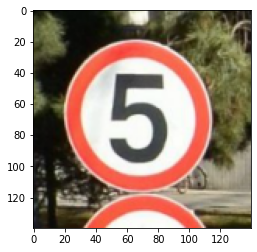

In [115]:
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))

In [116]:
img2=img1.reshape(1,140,140,3)

In [117]:
y_pred = final_mode.predict(img2)

In [118]:
pred_index = np.argmax(y_pred)
pred_index

0

In [119]:
print(label_text['Name'][pred_index])

Speed limit (5km/h)
